In [1]:
import pandas as pd
import numpy as np 
import re
from sklearn import preprocessing

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
test_ids = df_test["PassengerId"]
df_train.shape

(891, 12)

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
df_train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


# Get rid of columns that won't give insight in logistic regression

In [5]:
def drop_redundant_cols(data):
    data = data.drop(["PassengerId","Ticket"], axis = 1)

    return data

In [6]:
df_train = drop_redundant_cols(df_train)
df_test = drop_redundant_cols(df_test)

In [7]:
df_train.head(3)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,NaN,S


# Checking and assigning the correct data type groupings to the colunms

In [8]:
int_columns = list(df_train.select_dtypes(include = "int64"))
float_columns = list(df_train.select_dtypes(include = "float64"))
object_columns = list(df_train.select_dtypes(include = "object"))

cols = int_columns + float_columns + object_columns
cols

['Survived',
 'Pclass',
 'SibSp',
 'Parch',
 'Age',
 'Fare',
 'Name',
 'Sex',
 'Cabin',
 'Embarked']

# EDA on age to understand how to fill the missing age values

In [9]:
def fill_null_age(data):
    age_mean = data.groupby(["Sex","Pclass"])["Age"].transform('mean').round()

    data["Age"] = data["Age"].fillna(age_mean)

    return data

In [10]:
df_train = fill_null_age(df_train)
df_test = fill_null_age(df_test)

In [11]:
df_train.head(3)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,NaN,S


# Now to clean the Cabin column

In [12]:
def clean_cabin_col(data):
    data["Cabin"].fillna("U", inplace=True)
    data["Cabin"] = [word[0] for word in data["Cabin"]]

    return data

In [13]:
df_train = clean_cabin_col(df_train)
df_test = clean_cabin_col(df_test)

# Pulling the useful prefix from the name column

In [14]:
def pull_title_from_name(data):
    data["Name"] = [x.split(",")[1] for x in data['Name']]
    data['Name'] = [x.split(".")[0] for x in data['Name']]
    data = data.rename({"Name":"Title"}, axis=1)

    return data

In [15]:
df_train = pull_title_from_name(df_train)
df_test = pull_title_from_name(df_test)

# The cabin column has been cleaned, just need to assign the characters to numerical labels
# Make 'U' = 0

In [16]:
def apply_numerical_labels(data, cols):

    for col in cols:
        le = preprocessing.LabelEncoder()
        le.fit(data[col]) 
        data[col]= le.transform(data[col])

    return data

In [17]:
cols = ["Title", "Sex", "Cabin", "Embarked"]

In [18]:
df_train = apply_numerical_labels(df_train, cols)
df_test = apply_numerical_labels(df_test, cols)

In [19]:
df_train.head(3)

,Survived,Pclass,Title,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,11,1,22.0,1,0,7.2500,8,2
1,1,1,12,0,38.0,1,0,71.2833,2,0
2,1,3,8,0,26.0,0,0,7.9250,8,2


# Apply Logistic Regression to train the model 

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

### Before we can do the train and test split, we need X and y values
#### X --> Features that we using as independent variables in the model i.e. Name prefix, Sex, Pclass
#### Y --> The dependent variable we want to predict, "Survived

In [21]:
df_train.head()

,Survived,Pclass,Title,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,11,1,22.0,1,0,7.2500,8,2
1,1,1,12,0,38.0,1,0,71.2833,2,0
2,1,3,8,0,26.0,0,0,7.9250,8,2
3,1,1,12,0,35.0,1,0,53.1000,2,2
4,0,3,11,1,35.0,0,0,8.0500,8,2


In [22]:
## Drop/Remove survived and assign remaining features as X variables 
y = df_train["Survived"]
X = df_train.drop("Survived", axis=1)

In [23]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=42) 

In [24]:
clf = LogisticRegression(random_state=0, max_iter=1000).fit(X_train, y_train) 

In [25]:
predictions = clf.predict(X_val)

from sklearn.metrics import accuracy_score
accuracy_score(y_val,predictions)

0.8268156424581006

In [35]:
# One record with a null fare value
fare_mean = df_test.groupby(["Sex","Pclass","Embarked"])["Fare"].transform('mean')
df_test["Fare"] = df_test["Fare"].fillna(fare_mean)

In [36]:
submission_test_prediction = clf.predict(df_test)

In [38]:
len(submission_test_prediction)

418

In [39]:
len(df_test)

418

In [48]:
df_submission = pd.DataFrame({
    "PassengerId":test_ids.values,
    "Survived":submission_test_prediction
    })

In [51]:
df_submission.head(6)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
5,897,0


In [53]:
df_submission.to_csv('submission.csv', index=False)

In [58]:
import seaborn as sns 
import matplotlib.pyplot as plt

<Axes: xlabel='Sex', ylabel='count'>

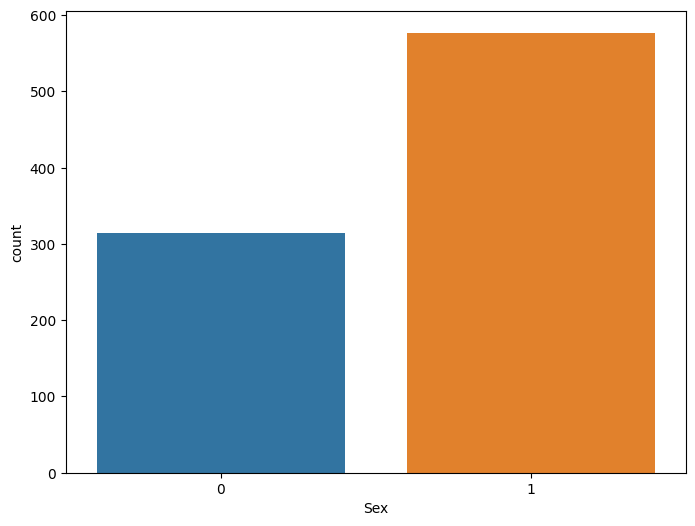

In [60]:
plt.figure(figsize=(8,6))
sns.countplot(x='Sex', data= df_train)

<Axes: xlabel='Sex', ylabel='count'>

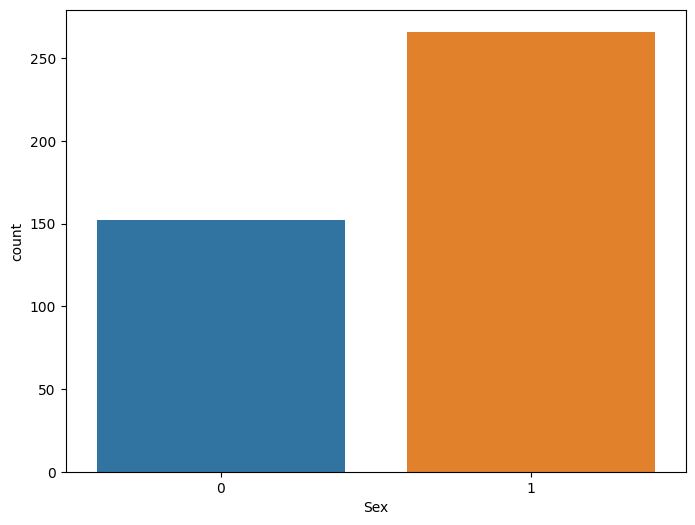

In [61]:
plt.figure(figsize=(8,6))
sns.countplot(x='Sex', data= df_test)